In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (classification_report, accuracy_score, make_scorer, 
                             roc_auc_score, confusion_matrix, plot_confusion_matrix)
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, 
                                   RobustScaler, FunctionTransformer, PolynomialFeatures)
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
# from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from geopy.distance import geodesic
import datetime

%matplotlib inline

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 0bf8bc6e-30d0-4c50-956a-603fc693d966.csv to 0bf8bc6e-30d0-4c50-956a-603fc693d966 (1).csv
Saving 702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv to 702ddfc5-68cd-4d1d-a0de-f5f566f76d91 (1).csv
Saving 4910797b-ee55-40a7-8668-10efd5c1b960.csv to 4910797b-ee55-40a7-8668-10efd5c1b960 (1).csv
Saving csvData.csv to csvData (1).csv
Saving tz.csv to tz (1).csv


## Data Import & Minimal Preprocessing




In [ ]:
# IMPORT DATASETS
y = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
X = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
final_test = pd.read_csv('702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv')

In [ ]:
# CONCAT X AND y TO CREATE 1 MASTER DATAFRAME
df = pd.concat([X, y], axis=1)

# DROP SOME COLUMNS
df = df.drop(['recorded_by', 'id'], axis=1)

# DROP DUPLICATED ENTRIES
df.drop_duplicates(keep='first', inplace=True)

## Train Test Split

The goal here is to have 3 sets of data:
1. **Training** `X_tt` - used for training
2. **Validation** `X_val` - used for model selection/tuning/tweaking
3. **Testing** `X_test` - used for testing

In [ ]:
X_master = df.drop('status_group', axis=1)
y_master = df.status_group

### 1. Master Training &  Testing sets



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_master, y_master, random_state=2021)

In [ ]:
print(f'Training: {X_train.shape} | {y_train.shape}')
print(f'Testing: {X_test.shape} | {y_test.shape}')

Training: (44523, 38) | (44523,)
Testing: (14841, 38) | (14841,)


### 2. Training & Validation sets

In [ ]:
# SPLIT 2: Training & Validation sets
X_tt, X_val, y_tt, y_val = train_test_split(X_train, y_train, random_state=2021)

In [ ]:
print(f'Training: {X_tt.shape} | {y_tt.shape}')
print(f'Validation: {X_val.shape} | {y_val.shape}')

Training: (33392, 38) | (33392,)
Validation: (11131, 38) | (11131,)


## Building Preprocessing Pipeline

### 1. Adding More Features

#### 1.1. Extract Month/Year and Age Recorded Information from `date_recorded`

In [ ]:
class DateTransformer(BaseEstimator, TransformerMixin):
  """Extracts information from datetime column to create new features

    Returns:
      month_recorded: first 3 character of name of the month recorded
      year_recorded: four-digit year
      age_recorded: difference between construction year and year recorded
   """

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    X['date_recorded'] = pd.to_datetime(X['date_recorded'])
    X['month_recorded'] = X.date_recorded.dt.month_name().str.slice(stop=3)
    X['year_recorded'] = X.date_recorded.dt.year
    X['age_recorded'] = X['year_recorded'] - X['construction_year']
    return self

#### 1.2. Adding Features Regarding Nearest Big City to the Water Wells by coordinates

In [ ]:
# Import Tanzania cities coordinates & population dataset
tanzania_cities = pd.read_csv('tz.csv')

# Import 2021 population dataset
tanzania_pop = pd.read_csv('csvData.csv')
tanzania_pop = tanzania_pop[['name', '2021']]
tanzania_pop.columns = ['city', 'population_2021']

# Merge 2 datasets on city names 
tz_df = tanzania_pop.merge(tanzania_cities, how='left', left_on='city', right_on='city')
tz_df.head()

# Drop the 2 population columns from the first df
tz_df.drop(['population', 'population_proper'], axis=1, inplace=True)

# Create another column that store the coordinates as a tuple
tz_df['coordinates'] = list(zip(tz_df.lat, tz_df.lng))

Then I will select the cities with population above 100,000 (this benchmark is currently arbitrary)

In [ ]:
tz_pop_above100k = tz_df[tz_df.population_2021 > 100000].copy()

# Drop rows with missing latitude and/or longitude
tz_pop_above100k.dropna(subset=['lat', 'lng'], inplace=True)

In [ ]:
def closest_point(x):
    '''
    Returns: a tuple
    - tuple[0]: name of nearest big city (population over 100000)
    - tuple[1]: geodesic distance from point x to nearest big city (tuple[0])
    '''
    
    output = None
    for _, city in tz_pop_above100k.iterrows():
        distance = geodesic(x, city.coordinates).km
        city_name = city.city
        if (output is None) or (distance < output[1]):
            output = (city_name, distance)
    return output

In [ ]:
class FeatureGenerator(BaseEstimator, TransformerMixin):
  """Generate extra features from wells' coordinates
    
    Returns:
      nearest_big_city_name: name of the nearest city with population over 100,000
      nearest_big_city_distance: distance to nearest city with population over 100,000
      nearest_big_city_population: population of nearest big city
   """
   
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    names = []
    distances = []
    populations = []
    for idx, row in X.iterrows():
        coordinates = (row['latitude'], row['longitude'])
        n, d = closest_point(coordinates)
        p = tz_df[tz_df.city == n].population_2021.values[0]
        names.append(n)
        distances.append(d)
        populations.append(p)
    X['nearest_big_city_name'] = names
    X['nearest_big_city_distance'] = distances
    X['nearest_big_city_population'] = populations
    return self

### 2. Preprocessing

#### 2.1. Fill in Missing Values with string `"NaN"`bold text in some Categorical & Boolean Features

`public_meeting`, `scheme_management`, `permit`

In [ ]:
class NaNImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        to_fillna = ['public_meeting', 'scheme_management', 'permit']
        X[to_fillna] = X[to_fillna].fillna(value='NaN')
        X[to_fillna] = X[to_fillna].astype(str)  
        return X

#### 2.2. Impute Longitude

In [ ]:
class LongitudeImputer(BaseEstimator, TransformerMixin):
    """
    Replaces invalid longitude value (0) with the aggregated means by region
    using region_code
    """
    def __init__(self):
        super().__init__()
        self.lng_means_ = {}

    def fit(self, X, y=None):
        self.lng_means_ = X.groupby(['region_code']).longitude.mean()
        return self

    def transform(self, X, y=None):
        # replace 0 with average longitude
        for key, value in self.lng_means_.items():
            X.loc[((X.longitude == 0) & (X.region_code == key)), 'longitude'] = value
        return X

#### 2.3. Binning Funder & Installer into 2 groups:
- `major` - top 100 funders or installers - responsible for around 80% of the water wells in the dataset used for fitting
- `minor` - any entities that are not in the top 100 list

##### 2.3.1. Funder

In [ ]:
class FunderBinner(BaseEstimator, TransformerMixin):
    """
    Categorize funders into 2 groups 'major' or minor'
    - 'major': top 100 funders in the fitted dataset
    - 'minor' - any entities that are not in the top 100 list
    """

    def __init__(self):
        super().__init__()
        self.top_100_funder = []

    def fit(self, X, y=None):
        self.top_100_funder = X.funder.value_counts()[:100].index
        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
            if row['funder'] in self.top_100_funder:
                val = 'major' 
            else:
                val = 'minor'
            X.loc[idx, 'funder'] = val
        return X

##### 2.3.2. Installer

In [ ]:
class InstallerBinner(BaseEstimator, TransformerMixin):
    """
    Categorize installers into 2 groups 'major' or minor'
    - 'major': top 100 funders in the fitted dataset
    - 'minor' - any entities that are not in the top 100 list
    """

    def __init__(self):
        super().__init__()
        self.top_100_installer = []

    def fit(self, X, y=None):
        self.top_100_installer = X.installer.value_counts()[:100].index

        return self

    def transform(self, X, y=None):
        for idx, row in X.iterrows():
            if row['installer'] in self.top_100_installer:
                val = 'major' 
            else:
                val = 'minor'
            X.loc[idx, 'installer'] = val
        return X

#### 2.4 Scaling Numerical Features

In [ ]:
# SELECT NUMERICAL FEATURES TO BE INCLUDED IN MODELING
numerical_features = ['amount_tsh', 'gps_height', 'num_private', 'construction_year', 'year_recorded', 'age_recorded',
                      'population', 'nearest_big_city_population', 'longitude', 'latitude', 'nearest_big_city_distance']

In [ ]:
numerical_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

#### 2.5. One Hot Encoding Categorical Features

In [ ]:
# SELECT CATEGORICAL FEATURES TO BE INCLUDED IN MODELING
categorical_features = ['funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group',
                        'quantity', 'source_class', 'waterpoint_type_group', 'nearest_big_city_name', 'month_recorded']

In [ ]:
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

## Preprocessing Pipeline

In [ ]:
# ADDING NEW FEATURES USING FeatureUnion
union = FeatureUnion(transformer_list=[('recorded', DateTransformer()),
                                       ('nearest_big_city', FeatureGenerator())])

# TRANSFORM NUMERICAL & CATEGORICAL FEATURES SEPARATELY USING ColumnTransformer
col_tranformer = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features),
                                                 ('cat', categorical_transformer, categorical_features)],
                                   remainder='drop')

# STACKING THEM TOGETHER IN A PIPELINE
preprocessor = Pipeline(steps=[('fillna', NaNImputer()),
                               ('lng_imp', LongitudeImputer()),
                               ('funder', FunderBinner()),
                               ('installer', InstallerBinner()),
                               ('col_tf', col_tranformer)])

## Modeling

In [ ]:
# CREATE NEW FEATURES IN TRAINING SET X_tt
union.fit_transform(X_tt)

array([DateTransformer(), FeatureGenerator()], dtype=object)

### 1. Random Forest Classifier

In [ ]:
def classification_report_with_accuracy_score(y_true, y_pred):
    """
    Returns Accuracy score while also printing out Classification Report
    """
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

scr_accuracy = make_scorer(classification_report_with_accuracy_score)

#### 1.1. With Class Imbalance

In [ ]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf', RandomForestClassifier(random_state=2021))])

scores_rf1 = cross_val_score(pipeline, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      3623
functional needs repair       0.49      0.33      0.40       483
         non functional       0.80      0.77      0.78      2573

               accuracy                           0.79      6679
              macro avg       0.70      0.65      0.67      6679
           weighted avg       0.78      0.79      0.78      6679

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.84      3623
functional needs repair       0.52      0.31      0.39       483
         non functional       0.81      0.78      0.80      2573

               accuracy                           0.80      6679
              macro avg       0.71      0.66      0.68      6679
           weighted avg       0.79      0.80      0.79      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf1.mean()

0.7905486530063138

#### Feature Importance

In [ ]:
rf1 = pipeline.fit(X_tt, y_tt)

In [ ]:
pipeline[0][4].named_transformers_['cat'][0].get_feature_names(input_features=categorical_features)

array(['funder_major', 'funder_minor', 'installer_major',
       'installer_minor', 'basin_Internal', 'basin_Lake Nyasa',
       'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria',
       'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast',
       'basin_Wami / Ruvu', 'region_Arusha', 'region_Dar es Salaam',
       'region_Dodoma', 'region_Iringa', 'region_Kagera', 'region_Kigoma',
       'region_Kilimanjaro', 'region_Lindi', 'region_Manyara',
       'region_Mara', 'region_Mbeya', 'region_Morogoro', 'region_Mtwara',
       'region_Mwanza', 'region_Pwani', 'region_Rukwa', 'region_Ruvuma',
       'region_Shinyanga', 'region_Singida', 'region_Tabora',
       'region_Tanga', 'public_meeting_False', 'public_meeting_NaN',
       'public_meeting_True', 'scheme_management_Company',
       'scheme_management_NaN', 'scheme_management_None',
       'scheme_management_Other', 'scheme_management_Parastatal',
       'scheme_management_Private operator', 'scheme_managemen

In [ ]:
ohe_cols = pipeline[0][4]\
                   .named_transformers_['cat']\
                   [0]\
                   .get_feature_names(input_features=categorical_features)
              
feature_importances = pd.DataFrame({'feature': np.array(numerical_features + list(ohe_cols)),
                                   'score': pipeline[1].feature_importances_}).sort_values(by='score', ascending=False)
feature_importances

,feature,score
8,longitude,0.102771
9,latitude,0.102274
10,nearest_big_city_distance,0.098715
89,quantity_dry,0.073278
1,gps_height,0.053007
...,...,...
97,waterpoint_type_group_cattle trough,0.000218
55,scheme_management_Trust,0.000208
54,scheme_management_SWC,0.000076
99,waterpoint_type_group_dam,0.000041


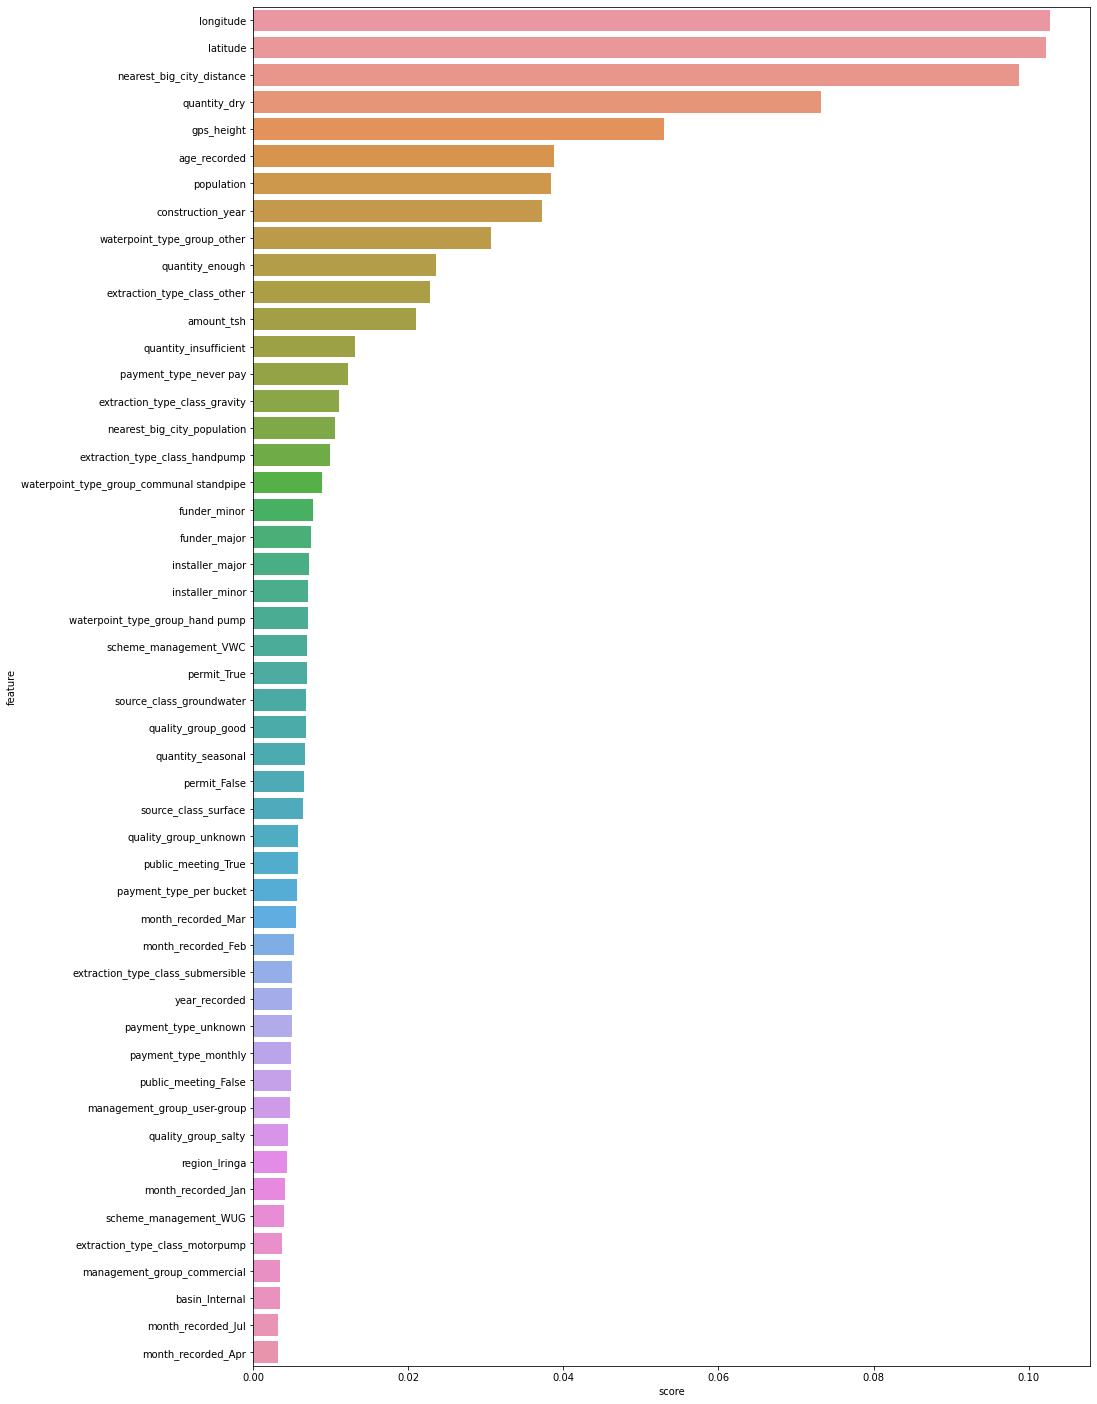

In [ ]:
# FEATURE IMPORTANCES VISUALIZATION
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importances[:50]);

#### 1.2. with SMOTE

In [ ]:
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021))])

scores_rf2 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.81      0.83      0.82      3623
functional needs repair       0.40      0.46      0.43       483
         non functional       0.81      0.76      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.68      0.68      6679
           weighted avg       0.78      0.77      0.78      6679

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      3623
functional needs repair       0.41      0.45      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.68      0.69      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf2.mean()

0.7795579570427235

In [ ]:
param_grid = [{
    'rf__n_estimators': [100, 300, 500],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [75, 90, 105, 120] 
}]

1. `criterion = 'entropy'`

In [ ]:
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, criterion='entropy'))])

scores_rf3 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.83      0.82      3623
functional needs repair       0.39      0.44      0.41       483
         non functional       0.81      0.75      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.67      0.67      6679
           weighted avg       0.78      0.77      0.77      6679

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      3623
functional needs repair       0.41      0.45      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.69      0.68      6679
           weighted avg       0.79      0.78      0.78      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf3.mean()

0.7780007525162008

2. `max_depth=75`

In [ ]:
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=75))])

scores_rf4 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.81      0.83      0.82      3623
functional needs repair       0.40      0.46      0.43       483
         non functional       0.81      0.76      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.68      0.68      6679
           weighted avg       0.78      0.77      0.78      6679

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      3623
functional needs repair       0.41      0.45      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.68      0.69      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf4.mean()

0.7795579570427235

3. `max_depth=150`

In [ ]:
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=150))])

scores_rf4 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.81      0.83      0.82      3623
functional needs repair       0.40      0.46      0.43       483
         non functional       0.81      0.76      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.68      0.68      6679
           weighted avg       0.78      0.77      0.78      6679

                         precision    recall  f1-score   support

             functional       0.82      0.84      0.83      3623
functional needs repair       0.41      0.45      0.43       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.79      6679
              macro avg       0.68      0.69      0.68      6679
           weighted avg       0.79      0.79      0.79      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf4.mean()

0.0

In [ ]:
# GRID SEARCH --> unsuccessful
param_grid = [{ 
    'rf__n_estimators': [200, 500],
    'rf__max_features': ['auto', 'sqrt', 'log2'], 
    'rf__max_depth' : [10, 100, 200],
    'rf__criterion' :['gini', 'entropy']
}]

pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, 
                                         sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021))])

gridsearch = GridSearchCV(estimator=pipe_sm, param_grid=param_grid, 
                          scoring='accuracy', n_jobs=-1, cv=3, verbose=2)
gridsearch.fit(X_tt, y_tt)


### 1.3. With Polynomial Features

In [ ]:
# max_depth = 200
# polynomial with interaction_only = True
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('poly', PolynomialFeatures(2, interaction_only=True)),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=200))])

scores_rf5 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      3623
functional needs repair       0.40      0.44      0.42       483
         non functional       0.81      0.75      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.68      0.67      6679
           weighted avg       0.78      0.77      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      3623
functional needs repair       0.41      0.43      0.42       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.68      0.68      6679
           weighted avg       0.79      0.78      0.79      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf5.mean()

0.780396535950271

In [ ]:
# max_depth = 20
# Polynomial(2) 
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('poly', PolynomialFeatures(2)),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=20))])

scores_rf5 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.79      0.84      0.82      3623
functional needs repair       0.34      0.55      0.42       483
         non functional       0.87      0.70      0.77      2573

               accuracy                           0.76      6679
              macro avg       0.67      0.70      0.67      6679
           weighted avg       0.79      0.76      0.77      6679

                         precision    recall  f1-score   support

             functional       0.80      0.85      0.83      3623
functional needs repair       0.35      0.53      0.42       483
         non functional       0.87      0.72      0.79      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.70      0.68      6679
           weighted avg       0.80      0.77      0.78      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf5.mean()

0.7684774362398118

In [ ]:
# max_depth = 300
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=300))])

scores_rf6 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.80      0.84      0.82      3623
functional needs repair       0.41      0.43      0.42       483
         non functional       0.81      0.75      0.78      2573

               accuracy                           0.77      6679
              macro avg       0.67      0.67      0.67      6679
           weighted avg       0.78      0.77      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.83      3623
functional needs repair       0.40      0.42      0.41       483
         non functional       0.82      0.77      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.68      0.68      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             funct

In [ ]:
scores_rf6.mean()

0.7797976080280232

In [ ]:
# max_depth = 100
# polynomial with interaction_only = True
# n_estimators = 200
pipe_sm = imbPipeline([('fillna', NaNImputer()),
                       ('lng_imp', LongitudeImputer()),
                       ('funder', FunderBinner()),
                       ('installer', InstallerBinner()),
                       ('col_tf', col_tranformer),
                       ('poly', PolynomialFeatures(2, interaction_only=True)),
                       ('sampler', SMOTE(random_state=2021, n_jobs=-1, sampling_strategy='minority')),
                       ('rf', RandomForestClassifier(random_state=2021, max_depth=100,
                                                     n_estimators=200))])

scores_rf5 = cross_val_score(pipe_sm, X_tt, y_tt, scoring=scr_accuracy)

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.82      3623
functional needs repair       0.40      0.44      0.42       483
         non functional       0.82      0.75      0.78      2573

               accuracy                           0.78      6679
              macro avg       0.67      0.68      0.67      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             functional       0.81      0.84      0.82      3623
functional needs repair       0.41      0.43      0.42       483
         non functional       0.82      0.76      0.79      2573

               accuracy                           0.78      6679
              macro avg       0.68      0.68      0.68      6679
           weighted avg       0.78      0.78      0.78      6679

                         precision    recall  f1-score   support

             funct

### Model Evaluation

In [ ]:
scores_rf5.mean()

0.7805463262237098

In [ ]:
# FIT MODEL ON THE WHOLE TRAINING DATA X_tt AND y_tt
rf5 = pipe_sm.fit(X_tt, y_tt)

In [ ]:
ohe_cols = pipe_sm[4].named_transformers_['cat'][0].get_feature_names(input_features=categorical_features)
cont_cat = numerical_features + list(ohe_cols)
col_names = pipe_sm[5].get_feature_names(input_features=cont_cat)

feature_importances = pd.DataFrame({'feature': col_names,
                                   'score': pipe_sm[7].feature_importances_}).sort_values(by='score', ascending=False)
feature_importances[:50]

,feature,score
725,year_recorded quantity_dry,0.005925
347,gps_height quantity_dry,0.005656
644,year_recorded longitude,0.005273
770,age_recorded nearest_big_city_distance,0.004805
90,quantity_dry,0.004744
768,age_recorded longitude,0.004685
769,age_recorded latitude,0.004675
9,longitude,0.004582
1136,longitude nearest_big_city_distance,0.004328
1135,longitude latitude,0.004314


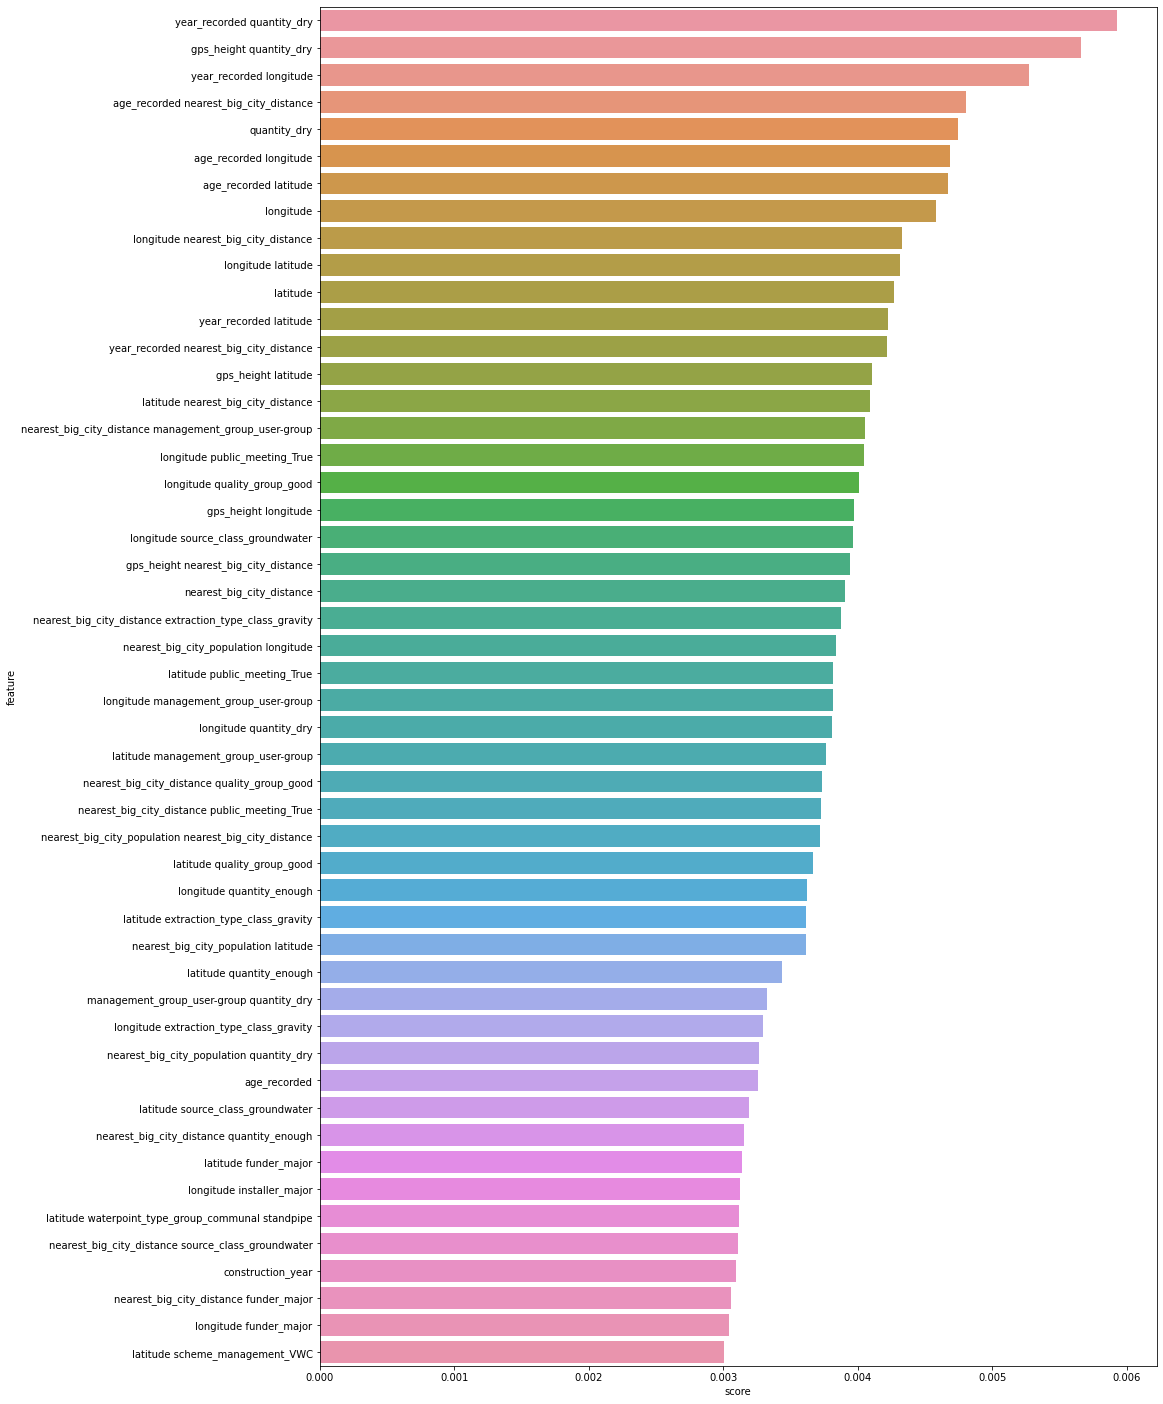

In [ ]:
# FEATURE IMPORTANCES VISUALIZATION
fig, ax = plt.subplots(1, figsize=(15, 25))
ax = sns.barplot(x='score', y='feature', data=feature_importances[:50]);

In [ ]:
# MAKE PREDICTIONS ON TRAINING SET
y_tt_pred = rf5.predict(X_tt)

In [ ]:
print(classification_report(y_tt, y_tt_pred))

                         precision    recall  f1-score   support

             functional       0.91      0.96      0.93     18112
functional needs repair       0.79      0.76      0.78      2412
         non functional       0.96      0.88      0.92     12868

               accuracy                           0.92     33392
              macro avg       0.89      0.87      0.88     33392
           weighted avg       0.92      0.92      0.92     33392



In [ ]:
labels = y_tt.unique()
confusion_matx = confusion_matrix(y_tt, y_tt_pred, labels=labels)

confusion_matx

array([[17465,   391,   256],
       [ 1346, 11302,   220],
       [  485,    92,  1835]])

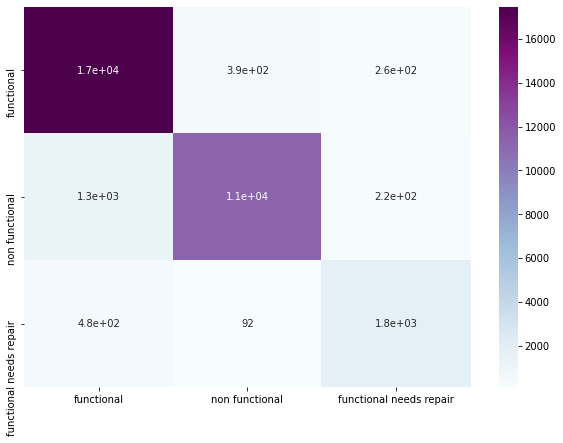

In [ ]:
df_cm = pd.DataFrame(confusion_matx, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu");

In [ ]:
# CREATE NEW FEATURES IN VALIDATION SET X_val
union.transform(X_val)

array([DateTransformer(), FeatureGenerator()], dtype=object)

In [ ]:
# MAKE PREDICTIONS ON VALIDATION SET
y_val_pred = rf5.predict(X_val)

In [ ]:
print(classification_report(y_val, y_val_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.85      0.83      6038
functional needs repair       0.41      0.46      0.44       819
         non functional       0.84      0.76      0.80      4274

               accuracy                           0.79     11131
              macro avg       0.69      0.69      0.69     11131
           weighted avg       0.79      0.79      0.79     11131



In [ ]:
confusion_matx_val = confusion_matrix(y_val, y_val_pred, labels=labels)

confusion_matx_val

array([[5121,  514,  403],
       [ 872, 3266,  136],
       [ 324,  117,  378]])

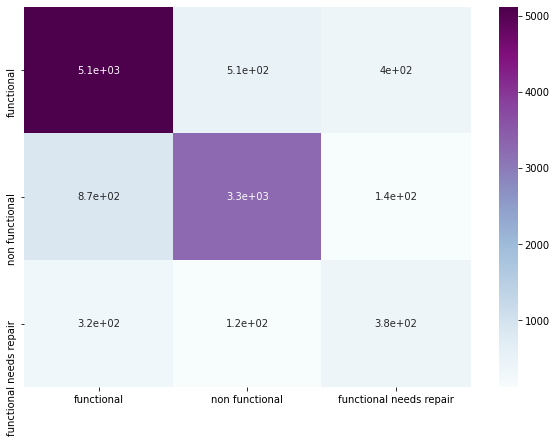

In [ ]:
df_cm = pd.DataFrame(confusion_matx_val, index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu");

In [ ]:
# CREATE NEW FEATURES IN MASTER TRAINING SET X_train
union.transform(X_train)

# FIT MODEL ON THE WHOLE TRAINING DATA X_train AND y_train
rf5 = pipe_sm.fit(X_train, y_train)

In [ ]:
# MAKE PREDICTIONS ON VALIDATION SET
y_train_pred = rf5.predict(X_train)
print(classification_report(y_train, y_train_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      1.00     24150
functional needs repair       0.95      0.99      0.97      3231
         non functional       1.00      1.00      1.00     17142

               accuracy                           0.99     44523
              macro avg       0.98      0.99      0.99     44523
           weighted avg       0.99      0.99      0.99     44523



In [ ]:
# CREATE NEW FEATURES IN MASTER TESTING SET X_test
union.transform(X_test)

# MAKE PREDICTIONS ON TEST SET
y_test_pred = rf5.predict(X_test)
print(classification_report(y_test, y_test_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.86      0.83      8087
functional needs repair       0.38      0.43      0.41      1083
         non functional       0.86      0.75      0.80      5671

               accuracy                           0.79     14841
              macro avg       0.68      0.68      0.68     14841
           weighted avg       0.79      0.79      0.79     14841



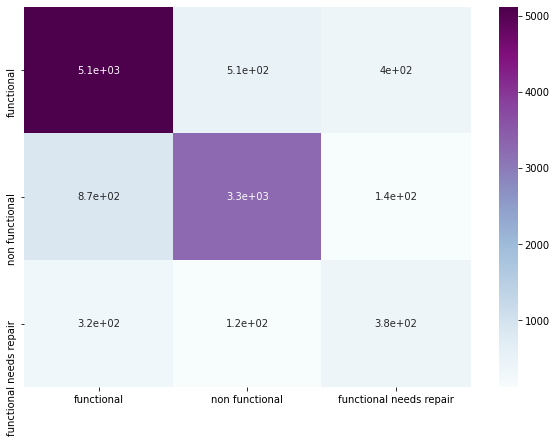

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_val, y_val_pred, labels=labels), 
                     index=labels, columns=labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="BuPu");